# Reference

https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

# Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import types
import random
import math

from pathlib import Path
from glob import glob
import numpy as np
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.utils.mobile_optimizer import optimize_for_mobile
import torchaudio
from torchaudio import transforms

# Arguments

In [3]:
args = types.SimpleNamespace()

args.dataroot = '/content/drive/MyDrive/watermelon_project/data/preprocessed'
args.n_epochs = 700
args.batch_size = 8
args.learning_rate = 0.001
args.sample_rate = 22050  # value per sec 
args.duration = 1000  # ms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


# Util

In [4]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])

        return ((resig, sr))

    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms
        
        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)
          
        return (sig, sr)

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

# Data

In [5]:
onehot_encoding = {
    'stage1': [1., 0., 0., 0., 0.],
    'stage2': [0., 1., 0., 0., 0.],
    'stage3': [0., 0., 1., 0., 0.],
    'blood': [0., 0., 0., 1., 0.],
    'virus': [0., 0., 0., 0., 1.],
}

classes = list(onehot_encoding.keys())

In [6]:
class AudioDS(Dataset):
    def __init__(self, dataroot, sr, duration):
        self.audio_paths = glob(args.dataroot + '/*/*.wav')

        self.sr = sr
        self.duration = duration
        self.channel = 2
        self.shift_pct = 0.4
              
    def __len__(self):
        return len(self.audio_paths)
      
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]

        audio = AudioUtil.open(audio_path)
        audio = AudioUtil.resample(audio, self.sr)
        audio = AudioUtil.rechannel(audio, self.channel)
        audio = AudioUtil.pad_trunc(audio, self.duration)
        audio = AudioUtil.time_shift(audio, self.shift_pct)
        mel = AudioUtil.spectro_gram(audio, n_mels=64, n_fft=1024, hop_len=None)
        mel = AudioUtil.spectro_augment(mel, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        label = Path(audio_path).parts[-2]
        label = onehot_encoding[label]
        label = torch.tensor(label)

        return mel, label

In [7]:
# Create dataset
ds = AudioDS(args.dataroot, args.sample_rate, args.duration)

# Random split (train:valid:test = 8:1:1)
num_items = len(ds)
num_train = round(num_items * 0.8)
train_ds, remain_ds = random_split(ds, [num_train, num_items - num_train])
num_remain = len(remain_ds)
num_val = round(num_remain * 0.5)
val_ds, test_ds = random_split(remain_ds, [num_val, num_remain - num_val])

print('total dataset length:', num_items)
print('train dataset length:', len(train_ds))
print('valid dataset length:', len(val_ds))
print('test dataset length:', len(test_ds))

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=args.batch_size)
test_dl = DataLoader(test_ds, batch_size=args.batch_size)

total dataset length: 2963
train dataset length: 2370
valid dataset length: 296
test dataset length: 297


# Model

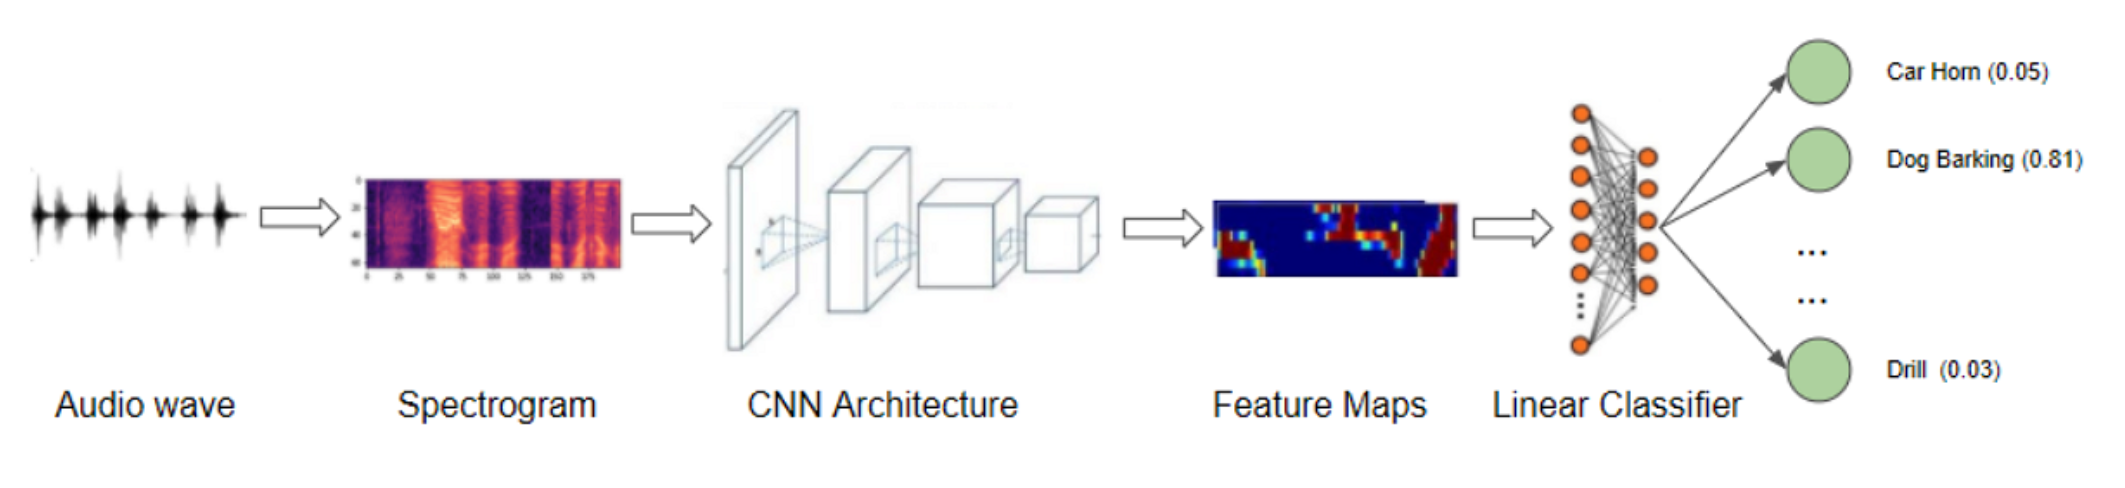

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=5)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [9]:
# Create the model
model = CNN().to(device)

# Train

In [10]:
# Set tensorboard logger
writer = SummaryWriter()

In [11]:
# Set loss function
loss_fn = nn.CrossEntropyLoss()

In [12]:
def evaluate(model, dl, loss_fn):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
      
    # Print stats at the end of the evaluation
    num_batches = len(dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction / total_prediction
    print(f'[Eval] Total items: {total_prediction}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    return avg_loss, acc

In [13]:
def train(model, train_dl, val_dl, loss_fn, n_epochs, lr):
    # Optimizer and Scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=n_epochs,
                                                    anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for data in train_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        print(f'[Train] Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

        # validation
        val_loss, val_acc = evaluate(model, val_dl, loss_fn)
        
        # logging
        writer.add_scalar('Train Loss', avg_loss, epoch)
        writer.add_scalar('Train Acc', acc, epoch)
        writer.add_scalar('Val Loss', val_loss, epoch)
        writer.add_scalar('Val Acc', val_acc, epoch)

    print('Finished Training')

# Run

In [ ]:
train(model, train_dl, val_dl, loss_fn, args.n_epochs, args.learning_rate)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

# Test

In [ ]:
test_loss, test_acc = evaluate(model, test_dl, loss_fn)

# Deployment

In [ ]:
class InferenceModel(nn.Module):
    def __init__(self, model, classes):
        super().__init__()
        self.model = model
        self.sr = 22050
        self.n_fft = 1024
        self.hop_len = None
        self.n_mels = 64
        self.top_db = 80.0
        self.mel_spectrogram = transforms.MelSpectrogram(self.sr, n_fft=self.n_fft, hop_length=self.hop_len, n_mels=self.n_mels)
        self.amplitude_to_db = transforms.AmplitudeToDB(top_db=self.top_db)
        self.classes = classes

    def rechannel(self, sig):
        resig = torch.cat([sig, sig])
        return resig

    def pad_trunc(self, sig):
        max_len = self.sr
        num_rows, sig_len = sig.shape
        
        if (sig_len > max_len):
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            pad_end_len = max_len - sig_len
            pad_end = torch.zeros((num_rows, pad_end_len))
            sig = torch.cat((sig, pad_end), 1)
          
        return sig

    def spectro_gram(self, sig):
        spec = self.mel_spectrogram(sig)
        spec = self.amplitude_to_db(spec)
        return (spec)
    
    def forward(self, sig):
        sig = self.rechannel(sig)
        sig = self.pad_trunc(sig)
        mel = self.spectro_gram(sig)
        mel = mel.unsqueeze(0)
        output = self.model(mel)
        _, pred = torch.max(output, 1)
        pred_str = self.classes[pred.item()]
        return pred_str

In [ ]:
model.eval()
model = model.cpu()
inference_model = InferenceModel(model, classes)
quantized_model = torch.quantization.quantize_dynamic(inference_model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)
scripted_model = torch.jit.script(quantized_model)
optimized_model = optimize_for_mobile(scripted_model)

waveform , _ = torchaudio.load('/content/drive/MyDrive/watermelon_project/data/preprocessed/stage3/120__(3)_1-2_segment9.wav')
print('Result:', optimized_model(waveform))

optimized_model._save_for_lite_interpreter("/content/drive/MyDrive/watermelon_project/audio_classifier.ptl")
print("Done")